# Code for writing the lung sound data to .ts file

Below is the code for writing the tromsø dataset to .ts files

In [1]:
import numpy as np
import pandas as pd
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
sys.path.insert(1, module_path + '/src')

import utility
import soundfile

import librosa
import sktime
from sktime.utils.data_io import load_from_tsfile_to_dataframe
from sklearn.model_selection import train_test_split

from math import ceil

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
from scipy.stats import skew 
import random

sys.path.insert(1, '/home/andrine/Desktop/tqwt_tools')
from tqwt_tools import DualQDecomposition
from scipy.signal import butter, lfilter
from scipy.fft import fft
from scipy.signal import stft
from scipy.stats import skew, kurtosis

from time import time
import sys
import os
figure_path = module_path + '/figures/'

sys.path.insert(1, module_path + '/src/')

from matplotlib.font_manager import FontProperties
font = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 10, weight = 1000)
font_small = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 8, weight = 1000)
colors = ['#F94144', '#90BE6D', '#577590','#F3722C', '#F8961E', '#F9844A', '#F9C74F', '#43AA8B', '#4D908E', '#277DA1']
colors_opa = ['#F9414466', '#90BE6D66', '#57759066','#F3722C66', '#F8961E66',
              '#F9844A66', '#F9C74F66', '#43AA8B66', '#4D908E66', '#277DA166']

sns.set_palette(sns.color_palette(colors))

def znorm(timeseries):
    mean = np.mean(timeseries)
    sd = np.std(timeseries)
    return (timeseries - mean)/sd

target_rate = 44100
ds_target_rate = 5000

import os
names = []
files_path = '/home/andrine/Desktop/dataTromso/Hasse413/'
#files_path = '/home/andrine/Desktop/dataTromsoFiltered/allFilteres/'

import pickle

with open(module_path + '/data/tromsoSummary.pkl', 'rb') as f:
    data = pickle.load(f)

Defining some helping functions, that will be important when extracting 

In [2]:
def get_sub_audios(audio, frac):
    base = len(audio)//frac
    half_base = base //2
    lengths = [(0, base)]

    while lengths[-1][1] < len(audio):
        lengths.append((lengths[-1][0] + base - half_base, lengths[-1][1] + base - half_base))

    sub_audio = []
    prev_len = len(audio[lengths[0][0]:lengths[0][1]])

    for l in lengths:
        sub = audio[l[0]:l[1]]
        if prev_len != len(sub):
            diff = prev_len - len(sub)
            sub = audio[l[0]- diff:l[1]]
            #print(diff)
        prev_len = len(sub)
        #print(len(sub))
        sub_audio.append(sub)
    return sub_audio

def get_entropy(audio):
    audio_nz = audio[audio != 0]
    return - np.sum(((audio_nz**2)*np.log(audio_nz**2)))
    
def get_energy(audio):  
    N = len(audio)
    return np.sum(np.abs(audio) ** 2) / N


def get_xf(y, sr):
    duration = float(len(y)) / sr
    T = 1.0/sr
    N = int(duration / T)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    return xf

def get_features(data, sr):
    sr = sr
    n_mfcc = 30
    ft1 = librosa.feature.mfcc(data, sr = sr, n_mfcc=n_mfcc)
    ft2 = librosa.feature.zero_crossing_rate(data)[0]
    ft3 = librosa.feature.spectral_rolloff(data)[0]
    ft4 = librosa.feature.spectral_centroid(data)[0]
    ft5 = librosa.feature.spectral_contrast(data)[0]
    ft6 = librosa.feature.spectral_bandwidth(data)[0]

    ### Get HOS and simple features 
    ft0_trunc = np.hstack((np.mean(data) , np.std(data), skew(data), np.max(data), np.median(data), np.min(data), utility.get_energy(data), utility.get_entropy(data)))

    ### MFCC features
    ft1_trunc = np.hstack((np.mean(ft1, axis=1), np.std(ft1, axis=1), skew(ft1, axis = 1), np.max(ft1, axis = 1), np.median(ft1, axis = 1), np.min(ft1, axis = 1)))

    ### Spectral Features 
    ft2_trunc = np.hstack((np.mean(ft2), np.std(ft2), skew(ft2), np.max(ft2), np.median(ft2), np.min(ft2)))
    ft3_trunc = np.hstack((np.mean(ft3), np.std(ft3), skew(ft3), np.max(ft3), np.median(ft3), np.min(ft3)))
    ft4_trunc = np.hstack((np.mean(ft4), np.std(ft4), skew(ft4), np.max(ft4), np.median(ft4), np.min(ft4)))
    ft5_trunc = np.hstack((np.mean(ft5), np.std(ft5), skew(ft5), np.max(ft5), np.median(ft5), np.min(ft5)))
    ft6_trunc = np.hstack((np.mean(ft6), np.std(ft6), skew(ft6), np.max(ft6), np.median(ft6), np.max(ft6)))
    return pd.Series(np.hstack((ft0_trunc , ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc, ft6_trunc)))



def zero_pad(ts, fixed_len):
    df_new = np.zeros(fixed_len)
    len_ts = len(ts)
    pad = (fixed_len - len_ts)//2
    df_new[pad:pad + len_ts] = ts
    return df_new


lowcut = 150
highcut = 2000
FRAME_RATE = 5000

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def bandpass_filter(buffer):
    return butter_bandpass_filter(buffer, lowcut, highcut, FRAME_RATE, order=12)

def get_sub_audios_no_overlap(audio, frac):
    base = len(audio)//frac
    sub_audio = []
    for n in range(frac):
        #print(n*base)
        if (n+1)*base < len(audio):
            sub = audio[n*base : (n+1)*base]
            sub_audio.append(sub)
            #print(len(sub))
        else:
            sub = audio[n*base :]
            #print(len(sub))
            diff = len(sub) - len(sub_audio[-1])
            if diff != 0:
                print(diff)
                sub = audio[n*base - diff :]
            sub_audio.append(sub)
            #print(len(sub))
            #print(diff)
    

    return sub_audio

def split_on_scilence(audio, sr):
    subs = librosa.effects.split(audio, top_db = 39, frame_length = 60, hop_length = 25) # Split on scilence
    new_ls = []
    last_sub = subs[0]
    curr_sub = [] # Subs makes too many splits, need to add some winodows together

    rms_median = np.median(librosa.feature.rms(audio, frame_length = 40, hop_length = 20)) 


    for i in range(len(subs)):
        curr_sub.append(subs[i])

        if ( curr_sub[-1][1] - curr_sub[0][0]) >  2.5*sr:  # Know that normal lung sounds usually lasts more than 2 seconds
            new_sub = audio[curr_sub[0][0] : curr_sub[-1][1]]
            rms_curr = np.mean(librosa.feature.rms(new_sub, frame_length = 50, hop_length = 25)) 
            
            if rms_curr > rms_median: # Make sure that window contains signal (lung sound has higher energy)
                new_ls.append(new_sub)

                #f, ax = plt.subplots(1,1)
                #f.set_size_inches(20, 5)


                #ax.plot(x[curr_sub[0][0] : curr_sub[-1][1]], new_sub, linewidth = 0.5)

                curr_sub = []  
                
    return new_ls

## Writing the data to a ts file 

In [16]:
new_dataset = data[data['label'] == 'normal'].copy(deep = True)
new_dataset.sort_values(by=['nr'], inplace=True)
new_dataset = new_dataset.iloc[:5000] # Limit time and complexity by just having 5000 samples

id_unique = new_dataset['nr'].unique()

id_train , id_test = train_test_split(id_unique, test_size=0.2, random_state=42)
id_train , id_val = train_test_split(id_unique, test_size=0.25, random_state=42)

new_dataset.reset_index(drop = False)


def get_indices(id_list, data):
    indices = np.array([])
    for i in id_list:
        idx = np.where(data['nr'] == i)[0]
        indices = np.append([list(idx)] , [indices])
        
    return indices

indices_train = get_indices(id_train, new_dataset).astype(int)
indices_test = get_indices(id_test, new_dataset).astype(int)
indices_val = get_indices(id_val, new_dataset).astype(int)

In [17]:
new_dataset['label'].value_counts()

normal    5000
Name: label, dtype: int64

In [64]:
file_splits = {
    '/data/ts_files/UiT_synthetic_250ms_1000hz_15s_TRAIN.ts' : indices_train,
    '/data/ts_files/UiT_synthetic_250ms_1000hz_15s_TEST.ts' : indices_test,
    '/data/ts_files/UiT_synthetic_250ms_1000hz_15s_VAL.ts' : indices_val
    
}
def make_synthetic(audio, sr):
    random_offset = random.random()
    test = librosa.tone(1000, sr=sr, length=0.25*sr, phi = random_offset)
    random_index = random.randint(0, len(audio) - len(test))
    new_audio = audio.copy()
    new_audio[random_index : random_index + len(test)] = new_audio[random_index : random_index + len(test)]  + test  
    return new_audio

def write_feature_extracted_dataset_to_ts(filename, data, frac):

    w = open(module_path + filename, 'w+')
    row = w.read()

    w.write('@problemName UiT lung sound \n')
    w.write('@timeStamps false \n')
    w.write('@missing false \n')
    w.write('@univariate true \n')
    w.write('@equalLength true \n')
    w.write('@classLabel true normal synthetic \n')
    w.write('@data \n')

    error_in_data = {}
    count = 0
    
    for row in data.iterrows():
       
        audio_file = row[1]['id']
        label = row[1]['label']

        try:
            sr, audio = utility.read_wav_file(audio_file, target_rate)

        except EOFError as error:
            error_in_data[audio_file] = 'EOFError'
            continue

        try:
            audio = utility.denoise_audio(audio)
            audio, sr = utility.downsample(audio, sr, 5000), 5000
            
            audio = np.apply_along_axis(bandpass_filter, 0, audio).astype('float64')
            audio = znorm(audio)
            '''
            sub_audio = get_sub_audios_no_overlap(audio, frac)
            
            #sub_audio = split_on_scilence(audio, sr)
            for sub in sub_audio: 
                #sub = znorm(sub)
                #sub = get_resonance_features(sub, sr)
            
                 
                if (count%2 == 0):
                    sub = make_synthetic(sub, sr)
                    label = 'synthetic'
                else:
                    label = 'normal'
                
                
                #sub = get_features(sub, sr)
                #print(label)
                sub = zero_pad(sub, 25000)
                new_row = str(list(sub))[1:-1].replace(' ', '') + ':' + label + '\n'
                w.write(new_row)
                count = count + 1
            
            '''
            if (count%2 == 0):
                audio = make_synthetic(audio, sr)
                label = 'synthetic'
            else:
                label = 'normal'
            #audio = get_features(audio, sr)
            audio = zero_pad(audio, 75000)
            new_row = str(list(audio))[1:-1].replace(' ', '') + ':' + label + '\n'
            w.write(new_row)
            count = count + 1
            
            print(f'Extracting file : {count}, of totally {len(data)}')    
            
        except ValueError as error:
            error_in_data[audio_file] = 'ValueError'
            continue
            
            
for name, i in file_splits.items():
    write_feature_extracted_dataset_to_ts(name, new_dataset.iloc[i],3)

Extracting file : 1, of totally 3762
Extracting file : 2, of totally 3762
Extracting file : 3, of totally 3762
Extracting file : 4, of totally 3762
Extracting file : 5, of totally 3762
Extracting file : 6, of totally 3762
Extracting file : 7, of totally 3762
Extracting file : 8, of totally 3762
Extracting file : 9, of totally 3762
Extracting file : 10, of totally 3762
Extracting file : 11, of totally 3762
Extracting file : 12, of totally 3762
Extracting file : 13, of totally 3762
Extracting file : 14, of totally 3762
Extracting file : 15, of totally 3762
Extracting file : 16, of totally 3762
Extracting file : 17, of totally 3762
Extracting file : 18, of totally 3762
Extracting file : 19, of totally 3762
Extracting file : 20, of totally 3762
Extracting file : 21, of totally 3762
Extracting file : 22, of totally 3762
Extracting file : 23, of totally 3762
Extracting file : 24, of totally 3762
Extracting file : 25, of totally 3762
Extracting file : 26, of totally 3762
Extracting file : 27,

Extracting file : 215, of totally 3762
Extracting file : 216, of totally 3762
Extracting file : 217, of totally 3762
Extracting file : 218, of totally 3762
Extracting file : 219, of totally 3762
Extracting file : 220, of totally 3762
Extracting file : 221, of totally 3762
Extracting file : 222, of totally 3762
Extracting file : 223, of totally 3762
Extracting file : 224, of totally 3762
Extracting file : 225, of totally 3762
Extracting file : 226, of totally 3762
Extracting file : 227, of totally 3762
Extracting file : 228, of totally 3762
Extracting file : 229, of totally 3762
Extracting file : 230, of totally 3762
Extracting file : 231, of totally 3762
Extracting file : 232, of totally 3762
Extracting file : 233, of totally 3762
Extracting file : 234, of totally 3762
Extracting file : 235, of totally 3762
Extracting file : 236, of totally 3762
Extracting file : 237, of totally 3762
Extracting file : 238, of totally 3762
Extracting file : 239, of totally 3762
Extracting file : 240, of

Extracting file : 427, of totally 3762
Extracting file : 428, of totally 3762
Extracting file : 429, of totally 3762
Extracting file : 430, of totally 3762
Extracting file : 431, of totally 3762
Extracting file : 432, of totally 3762
Extracting file : 433, of totally 3762
Extracting file : 434, of totally 3762
Extracting file : 435, of totally 3762
Extracting file : 436, of totally 3762
Extracting file : 437, of totally 3762
Extracting file : 438, of totally 3762
Extracting file : 439, of totally 3762
Extracting file : 440, of totally 3762
Extracting file : 441, of totally 3762
Extracting file : 442, of totally 3762
Extracting file : 443, of totally 3762
Extracting file : 444, of totally 3762
Extracting file : 445, of totally 3762
Extracting file : 446, of totally 3762
Extracting file : 447, of totally 3762
Extracting file : 448, of totally 3762
Extracting file : 449, of totally 3762
Extracting file : 450, of totally 3762
Extracting file : 451, of totally 3762
Extracting file : 452, of

Extracting file : 638, of totally 3762
Extracting file : 639, of totally 3762
Extracting file : 640, of totally 3762
Extracting file : 641, of totally 3762
Extracting file : 642, of totally 3762
Extracting file : 643, of totally 3762
Extracting file : 644, of totally 3762
Extracting file : 645, of totally 3762
Extracting file : 646, of totally 3762
Extracting file : 647, of totally 3762
Extracting file : 648, of totally 3762
Extracting file : 649, of totally 3762
Extracting file : 650, of totally 3762
Extracting file : 651, of totally 3762
Extracting file : 652, of totally 3762
Extracting file : 653, of totally 3762
Extracting file : 654, of totally 3762
Extracting file : 655, of totally 3762
Extracting file : 656, of totally 3762
Extracting file : 657, of totally 3762
Extracting file : 658, of totally 3762
Extracting file : 659, of totally 3762
Extracting file : 660, of totally 3762
Extracting file : 661, of totally 3762
Extracting file : 662, of totally 3762
Extracting file : 663, of

Extracting file : 849, of totally 3762
Extracting file : 850, of totally 3762
Extracting file : 851, of totally 3762
Extracting file : 852, of totally 3762
Extracting file : 853, of totally 3762
Extracting file : 854, of totally 3762
Extracting file : 855, of totally 3762
Extracting file : 856, of totally 3762
Extracting file : 857, of totally 3762
Extracting file : 858, of totally 3762
Extracting file : 859, of totally 3762
Extracting file : 860, of totally 3762
Extracting file : 861, of totally 3762
Extracting file : 862, of totally 3762
Extracting file : 863, of totally 3762
Extracting file : 864, of totally 3762
Extracting file : 865, of totally 3762
Extracting file : 866, of totally 3762
Extracting file : 867, of totally 3762
Extracting file : 868, of totally 3762
Extracting file : 869, of totally 3762
Extracting file : 870, of totally 3762
Extracting file : 871, of totally 3762
Extracting file : 872, of totally 3762
Extracting file : 873, of totally 3762
Extracting file : 874, of

Extracting file : 1058, of totally 3762
Extracting file : 1059, of totally 3762
Extracting file : 1060, of totally 3762
Extracting file : 1061, of totally 3762
Extracting file : 1062, of totally 3762
Extracting file : 1063, of totally 3762
Extracting file : 1064, of totally 3762
Extracting file : 1065, of totally 3762
Extracting file : 1066, of totally 3762
Extracting file : 1067, of totally 3762
Extracting file : 1068, of totally 3762
Extracting file : 1069, of totally 3762
Extracting file : 1070, of totally 3762
Extracting file : 1071, of totally 3762
Extracting file : 1072, of totally 3762
Extracting file : 1073, of totally 3762
Extracting file : 1074, of totally 3762
Extracting file : 1075, of totally 3762
Extracting file : 1076, of totally 3762
Extracting file : 1077, of totally 3762
Extracting file : 1078, of totally 3762
Extracting file : 1079, of totally 3762
Extracting file : 1080, of totally 3762
Extracting file : 1081, of totally 3762
Extracting file : 1082, of totally 3762


Extracting file : 1263, of totally 3762
Extracting file : 1264, of totally 3762
Extracting file : 1265, of totally 3762
Extracting file : 1266, of totally 3762
Extracting file : 1267, of totally 3762
Extracting file : 1268, of totally 3762
Extracting file : 1269, of totally 3762
Extracting file : 1270, of totally 3762
Extracting file : 1271, of totally 3762
Extracting file : 1272, of totally 3762
Extracting file : 1273, of totally 3762
Extracting file : 1274, of totally 3762
Extracting file : 1275, of totally 3762
Extracting file : 1276, of totally 3762
Extracting file : 1277, of totally 3762
Extracting file : 1278, of totally 3762
Extracting file : 1279, of totally 3762
Extracting file : 1280, of totally 3762
Extracting file : 1281, of totally 3762
Extracting file : 1282, of totally 3762
Extracting file : 1283, of totally 3762
Extracting file : 1284, of totally 3762
Extracting file : 1285, of totally 3762
Extracting file : 1286, of totally 3762
Extracting file : 1287, of totally 3762


Extracting file : 1468, of totally 3762
Extracting file : 1469, of totally 3762
Extracting file : 1470, of totally 3762
Extracting file : 1471, of totally 3762
Extracting file : 1472, of totally 3762
Extracting file : 1473, of totally 3762
Extracting file : 1474, of totally 3762
Extracting file : 1475, of totally 3762
Extracting file : 1476, of totally 3762
Extracting file : 1477, of totally 3762
Extracting file : 1478, of totally 3762
Extracting file : 1479, of totally 3762
Extracting file : 1480, of totally 3762
Extracting file : 1481, of totally 3762
Extracting file : 1482, of totally 3762
Extracting file : 1483, of totally 3762
Extracting file : 1484, of totally 3762
Extracting file : 1485, of totally 3762
Extracting file : 1486, of totally 3762
Extracting file : 1487, of totally 3762
Extracting file : 1488, of totally 3762
Extracting file : 1489, of totally 3762
Extracting file : 1490, of totally 3762
Extracting file : 1491, of totally 3762
Extracting file : 1492, of totally 3762


Extracting file : 1674, of totally 3762
Extracting file : 1675, of totally 3762
Extracting file : 1676, of totally 3762
Extracting file : 1677, of totally 3762
Extracting file : 1678, of totally 3762
Extracting file : 1679, of totally 3762
Extracting file : 1680, of totally 3762
Extracting file : 1681, of totally 3762
Extracting file : 1682, of totally 3762
Extracting file : 1683, of totally 3762
Extracting file : 1684, of totally 3762
Extracting file : 1685, of totally 3762
Extracting file : 1686, of totally 3762
Extracting file : 1687, of totally 3762
Extracting file : 1688, of totally 3762
Extracting file : 1689, of totally 3762
Extracting file : 1690, of totally 3762
Extracting file : 1691, of totally 3762
Extracting file : 1692, of totally 3762
Extracting file : 1693, of totally 3762
Extracting file : 1694, of totally 3762
Extracting file : 1695, of totally 3762
Extracting file : 1696, of totally 3762
Extracting file : 1697, of totally 3762
Extracting file : 1698, of totally 3762


Extracting file : 1879, of totally 3762
Extracting file : 1880, of totally 3762
Extracting file : 1881, of totally 3762
Extracting file : 1882, of totally 3762
Extracting file : 1883, of totally 3762
Extracting file : 1884, of totally 3762
Extracting file : 1885, of totally 3762
Extracting file : 1886, of totally 3762
Extracting file : 1887, of totally 3762
Extracting file : 1888, of totally 3762
Extracting file : 1889, of totally 3762
Extracting file : 1890, of totally 3762
Extracting file : 1891, of totally 3762
Extracting file : 1892, of totally 3762
Extracting file : 1893, of totally 3762
Extracting file : 1894, of totally 3762
Extracting file : 1895, of totally 3762
Extracting file : 1896, of totally 3762
Extracting file : 1897, of totally 3762
Extracting file : 1898, of totally 3762
Extracting file : 1899, of totally 3762
Extracting file : 1900, of totally 3762
Extracting file : 1901, of totally 3762
Extracting file : 1902, of totally 3762
Extracting file : 1903, of totally 3762


/home/andrine/Desktop/AndrineElsetronning_Master2021/src/utility.py:212: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (rate, data) = wf.read(str_filename)


Extracting file : 2043, of totally 3762
Extracting file : 2044, of totally 3762
Extracting file : 2045, of totally 3762
Extracting file : 2046, of totally 3762
Extracting file : 2047, of totally 3762
Extracting file : 2048, of totally 3762
Extracting file : 2049, of totally 3762
Extracting file : 2050, of totally 3762
Extracting file : 2051, of totally 3762
Extracting file : 2052, of totally 3762
Extracting file : 2053, of totally 3762
Extracting file : 2054, of totally 3762
Extracting file : 2055, of totally 3762
Extracting file : 2056, of totally 3762
Extracting file : 2057, of totally 3762
Extracting file : 2058, of totally 3762
Extracting file : 2059, of totally 3762
Extracting file : 2060, of totally 3762
Extracting file : 2061, of totally 3762
Extracting file : 2062, of totally 3762
Extracting file : 2063, of totally 3762
Extracting file : 2064, of totally 3762
Extracting file : 2065, of totally 3762
Extracting file : 2066, of totally 3762
Extracting file : 2067, of totally 3762


Extracting file : 2249, of totally 3762
Extracting file : 2250, of totally 3762
Extracting file : 2251, of totally 3762
Extracting file : 2252, of totally 3762
Extracting file : 2253, of totally 3762
Extracting file : 2254, of totally 3762
Extracting file : 2255, of totally 3762
Extracting file : 2256, of totally 3762
Extracting file : 2257, of totally 3762
Extracting file : 2258, of totally 3762
Extracting file : 2259, of totally 3762
Extracting file : 2260, of totally 3762
Extracting file : 2261, of totally 3762
Extracting file : 2262, of totally 3762
Extracting file : 2263, of totally 3762
Extracting file : 2264, of totally 3762
Extracting file : 2265, of totally 3762
Extracting file : 2266, of totally 3762
Extracting file : 2267, of totally 3762
Extracting file : 2268, of totally 3762
Extracting file : 2269, of totally 3762
Extracting file : 2270, of totally 3762
Extracting file : 2271, of totally 3762
Extracting file : 2272, of totally 3762
Extracting file : 2273, of totally 3762


Extracting file : 2454, of totally 3762
Extracting file : 2455, of totally 3762
Extracting file : 2456, of totally 3762
Extracting file : 2457, of totally 3762
Extracting file : 2458, of totally 3762
Extracting file : 2459, of totally 3762
Extracting file : 2460, of totally 3762
Extracting file : 2461, of totally 3762
Extracting file : 2462, of totally 3762
Extracting file : 2463, of totally 3762
Extracting file : 2464, of totally 3762
Extracting file : 2465, of totally 3762
Extracting file : 2466, of totally 3762
Extracting file : 2467, of totally 3762
Extracting file : 2468, of totally 3762
Extracting file : 2469, of totally 3762
Extracting file : 2470, of totally 3762
Extracting file : 2471, of totally 3762
Extracting file : 2472, of totally 3762
Extracting file : 2473, of totally 3762
Extracting file : 2474, of totally 3762
Extracting file : 2475, of totally 3762
Extracting file : 2476, of totally 3762
Extracting file : 2477, of totally 3762
Extracting file : 2478, of totally 3762


Extracting file : 2659, of totally 3762
Extracting file : 2660, of totally 3762
Extracting file : 2661, of totally 3762
Extracting file : 2662, of totally 3762
Extracting file : 2663, of totally 3762
Extracting file : 2664, of totally 3762
Extracting file : 2665, of totally 3762
Extracting file : 2666, of totally 3762
Extracting file : 2667, of totally 3762
Extracting file : 2668, of totally 3762
Extracting file : 2669, of totally 3762
Extracting file : 2670, of totally 3762
Extracting file : 2671, of totally 3762
Extracting file : 2672, of totally 3762
Extracting file : 2673, of totally 3762
Extracting file : 2674, of totally 3762
Extracting file : 2675, of totally 3762
Extracting file : 2676, of totally 3762
Extracting file : 2677, of totally 3762
Extracting file : 2678, of totally 3762
Extracting file : 2679, of totally 3762
Extracting file : 2680, of totally 3762
Extracting file : 2681, of totally 3762
Extracting file : 2682, of totally 3762
Extracting file : 2683, of totally 3762


Extracting file : 2864, of totally 3762
Extracting file : 2865, of totally 3762
Extracting file : 2866, of totally 3762
Extracting file : 2867, of totally 3762
Extracting file : 2868, of totally 3762
Extracting file : 2869, of totally 3762
Extracting file : 2870, of totally 3762
Extracting file : 2871, of totally 3762
Extracting file : 2872, of totally 3762
Extracting file : 2873, of totally 3762
Extracting file : 2874, of totally 3762
Extracting file : 2875, of totally 3762
Extracting file : 2876, of totally 3762
Extracting file : 2877, of totally 3762
Extracting file : 2878, of totally 3762
Extracting file : 2879, of totally 3762
Extracting file : 2880, of totally 3762
Extracting file : 2881, of totally 3762
Extracting file : 2882, of totally 3762
Extracting file : 2883, of totally 3762
Extracting file : 2884, of totally 3762
Extracting file : 2885, of totally 3762
Extracting file : 2886, of totally 3762
Extracting file : 2887, of totally 3762
Extracting file : 2888, of totally 3762


Extracting file : 3069, of totally 3762
Extracting file : 3070, of totally 3762
Extracting file : 3071, of totally 3762
Extracting file : 3072, of totally 3762
Extracting file : 3073, of totally 3762
Extracting file : 3074, of totally 3762
Extracting file : 3075, of totally 3762
Extracting file : 3076, of totally 3762
Extracting file : 3077, of totally 3762
Extracting file : 3078, of totally 3762
Extracting file : 3079, of totally 3762
Extracting file : 3080, of totally 3762
Extracting file : 3081, of totally 3762
Extracting file : 3082, of totally 3762
Extracting file : 3083, of totally 3762
Extracting file : 3084, of totally 3762
Extracting file : 3085, of totally 3762
Extracting file : 3086, of totally 3762
Extracting file : 3087, of totally 3762
Extracting file : 3088, of totally 3762
Extracting file : 3089, of totally 3762
Extracting file : 3090, of totally 3762
Extracting file : 3091, of totally 3762
Extracting file : 3092, of totally 3762
Extracting file : 3093, of totally 3762


Extracting file : 3274, of totally 3762
Extracting file : 3275, of totally 3762
Extracting file : 3276, of totally 3762
Extracting file : 3277, of totally 3762
Extracting file : 3278, of totally 3762
Extracting file : 3279, of totally 3762
Extracting file : 3280, of totally 3762
Extracting file : 3281, of totally 3762
Extracting file : 3282, of totally 3762
Extracting file : 3283, of totally 3762
Extracting file : 3284, of totally 3762
Extracting file : 3285, of totally 3762
Extracting file : 3286, of totally 3762
Extracting file : 3287, of totally 3762
Extracting file : 3288, of totally 3762
Extracting file : 3289, of totally 3762
Extracting file : 3290, of totally 3762
Extracting file : 3291, of totally 3762
Extracting file : 3292, of totally 3762
Extracting file : 3293, of totally 3762
Extracting file : 3294, of totally 3762
Extracting file : 3295, of totally 3762
Extracting file : 3296, of totally 3762
Extracting file : 3297, of totally 3762
Extracting file : 3298, of totally 3762


Extracting file : 3479, of totally 3762
Extracting file : 3480, of totally 3762
Extracting file : 3481, of totally 3762
Extracting file : 3482, of totally 3762
Extracting file : 3483, of totally 3762
Extracting file : 3484, of totally 3762
Extracting file : 3485, of totally 3762
Extracting file : 3486, of totally 3762
Extracting file : 3487, of totally 3762
Extracting file : 3488, of totally 3762
Extracting file : 3489, of totally 3762
Extracting file : 3490, of totally 3762
Extracting file : 3491, of totally 3762
Extracting file : 3492, of totally 3762
Extracting file : 3493, of totally 3762
Extracting file : 3494, of totally 3762
Extracting file : 3495, of totally 3762
Extracting file : 3496, of totally 3762
Extracting file : 3497, of totally 3762
Extracting file : 3498, of totally 3762
Extracting file : 3499, of totally 3762
Extracting file : 3500, of totally 3762
Extracting file : 3501, of totally 3762
Extracting file : 3502, of totally 3762
Extracting file : 3503, of totally 3762


Extracting file : 3684, of totally 3762
Extracting file : 3685, of totally 3762
Extracting file : 3686, of totally 3762
Extracting file : 3687, of totally 3762
Extracting file : 3688, of totally 3762
Extracting file : 3689, of totally 3762
Extracting file : 3690, of totally 3762
Extracting file : 3691, of totally 3762
Extracting file : 3692, of totally 3762
Extracting file : 3693, of totally 3762
Extracting file : 3694, of totally 3762
Extracting file : 3695, of totally 3762
Extracting file : 3696, of totally 3762
Extracting file : 3697, of totally 3762
Extracting file : 3698, of totally 3762
Extracting file : 3699, of totally 3762
Extracting file : 3700, of totally 3762
Extracting file : 3701, of totally 3762
Extracting file : 3702, of totally 3762
Extracting file : 3703, of totally 3762
Extracting file : 3704, of totally 3762
Extracting file : 3705, of totally 3762
Extracting file : 3706, of totally 3762
Extracting file : 3707, of totally 3762
Extracting file : 3708, of totally 3762


Extracting file : 139, of totally 990
Extracting file : 140, of totally 990
Extracting file : 141, of totally 990
Extracting file : 142, of totally 990
Extracting file : 143, of totally 990
Extracting file : 144, of totally 990
Extracting file : 145, of totally 990
Extracting file : 146, of totally 990
Extracting file : 147, of totally 990
Extracting file : 148, of totally 990
Extracting file : 149, of totally 990
Extracting file : 150, of totally 990
Extracting file : 151, of totally 990
Extracting file : 152, of totally 990
Extracting file : 153, of totally 990
Extracting file : 154, of totally 990
Extracting file : 155, of totally 990
Extracting file : 156, of totally 990
Extracting file : 157, of totally 990
Extracting file : 158, of totally 990
Extracting file : 159, of totally 990
Extracting file : 160, of totally 990
Extracting file : 161, of totally 990
Extracting file : 162, of totally 990
Extracting file : 163, of totally 990
Extracting file : 164, of totally 990
Extracting f

Extracting file : 355, of totally 990
Extracting file : 356, of totally 990
Extracting file : 357, of totally 990
Extracting file : 358, of totally 990
Extracting file : 359, of totally 990
Extracting file : 360, of totally 990
Extracting file : 361, of totally 990
Extracting file : 362, of totally 990
Extracting file : 363, of totally 990
Extracting file : 364, of totally 990
Extracting file : 365, of totally 990
Extracting file : 366, of totally 990
Extracting file : 367, of totally 990
Extracting file : 368, of totally 990
Extracting file : 369, of totally 990
Extracting file : 370, of totally 990
Extracting file : 371, of totally 990
Extracting file : 372, of totally 990
Extracting file : 373, of totally 990
Extracting file : 374, of totally 990
Extracting file : 375, of totally 990
Extracting file : 376, of totally 990
Extracting file : 377, of totally 990
Extracting file : 378, of totally 990
Extracting file : 379, of totally 990
Extracting file : 380, of totally 990
Extracting f

Extracting file : 571, of totally 990
Extracting file : 572, of totally 990
Extracting file : 573, of totally 990
Extracting file : 574, of totally 990
Extracting file : 575, of totally 990
Extracting file : 576, of totally 990
Extracting file : 577, of totally 990
Extracting file : 578, of totally 990
Extracting file : 579, of totally 990
Extracting file : 580, of totally 990
Extracting file : 581, of totally 990
Extracting file : 582, of totally 990
Extracting file : 583, of totally 990
Extracting file : 584, of totally 990
Extracting file : 585, of totally 990
Extracting file : 586, of totally 990
Extracting file : 587, of totally 990
Extracting file : 588, of totally 990
Extracting file : 589, of totally 990
Extracting file : 590, of totally 990
Extracting file : 591, of totally 990
Extracting file : 592, of totally 990
Extracting file : 593, of totally 990
Extracting file : 594, of totally 990
Extracting file : 595, of totally 990
Extracting file : 596, of totally 990
Extracting f

Extracting file : 787, of totally 990
Extracting file : 788, of totally 990
Extracting file : 789, of totally 990
Extracting file : 790, of totally 990
Extracting file : 791, of totally 990
Extracting file : 792, of totally 990
Extracting file : 793, of totally 990
Extracting file : 794, of totally 990
Extracting file : 795, of totally 990
Extracting file : 796, of totally 990
Extracting file : 797, of totally 990
Extracting file : 798, of totally 990
Extracting file : 799, of totally 990
Extracting file : 800, of totally 990
Extracting file : 801, of totally 990
Extracting file : 802, of totally 990
Extracting file : 803, of totally 990
Extracting file : 804, of totally 990
Extracting file : 805, of totally 990
Extracting file : 806, of totally 990
Extracting file : 807, of totally 990
Extracting file : 808, of totally 990
Extracting file : 809, of totally 990
Extracting file : 810, of totally 990
Extracting file : 811, of totally 990
Extracting file : 812, of totally 990
Extracting f

Extracting file : 14, of totally 1238
Extracting file : 15, of totally 1238
Extracting file : 16, of totally 1238
Extracting file : 17, of totally 1238
Extracting file : 18, of totally 1238
Extracting file : 19, of totally 1238
Extracting file : 20, of totally 1238
Extracting file : 21, of totally 1238
Extracting file : 22, of totally 1238
Extracting file : 23, of totally 1238
Extracting file : 24, of totally 1238
Extracting file : 25, of totally 1238
Extracting file : 26, of totally 1238
Extracting file : 27, of totally 1238
Extracting file : 28, of totally 1238
Extracting file : 29, of totally 1238
Extracting file : 30, of totally 1238
Extracting file : 31, of totally 1238
Extracting file : 32, of totally 1238
Extracting file : 33, of totally 1238
Extracting file : 34, of totally 1238
Extracting file : 35, of totally 1238
Extracting file : 36, of totally 1238
Extracting file : 37, of totally 1238
Extracting file : 38, of totally 1238
Extracting file : 39, of totally 1238
Extracting f

Extracting file : 228, of totally 1238
Extracting file : 229, of totally 1238
Extracting file : 230, of totally 1238
Extracting file : 231, of totally 1238
Extracting file : 232, of totally 1238
Extracting file : 233, of totally 1238
Extracting file : 234, of totally 1238
Extracting file : 235, of totally 1238
Extracting file : 236, of totally 1238
Extracting file : 237, of totally 1238
Extracting file : 238, of totally 1238
Extracting file : 239, of totally 1238
Extracting file : 240, of totally 1238
Extracting file : 241, of totally 1238
Extracting file : 242, of totally 1238
Extracting file : 243, of totally 1238
Extracting file : 244, of totally 1238
Extracting file : 245, of totally 1238
Extracting file : 246, of totally 1238
Extracting file : 247, of totally 1238
Extracting file : 248, of totally 1238
Extracting file : 249, of totally 1238
Extracting file : 250, of totally 1238
Extracting file : 251, of totally 1238
Extracting file : 252, of totally 1238
Extracting file : 253, of

Extracting file : 440, of totally 1238
Extracting file : 441, of totally 1238
Extracting file : 442, of totally 1238
Extracting file : 443, of totally 1238
Extracting file : 444, of totally 1238
Extracting file : 445, of totally 1238
Extracting file : 446, of totally 1238
Extracting file : 447, of totally 1238
Extracting file : 448, of totally 1238
Extracting file : 449, of totally 1238
Extracting file : 450, of totally 1238
Extracting file : 451, of totally 1238
Extracting file : 452, of totally 1238
Extracting file : 453, of totally 1238
Extracting file : 454, of totally 1238
Extracting file : 455, of totally 1238
Extracting file : 456, of totally 1238
Extracting file : 457, of totally 1238
Extracting file : 458, of totally 1238
Extracting file : 459, of totally 1238
Extracting file : 460, of totally 1238
Extracting file : 461, of totally 1238
Extracting file : 462, of totally 1238
Extracting file : 463, of totally 1238
Extracting file : 464, of totally 1238
Extracting file : 465, of

Extracting file : 651, of totally 1238
Extracting file : 652, of totally 1238
Extracting file : 653, of totally 1238
Extracting file : 654, of totally 1238
Extracting file : 655, of totally 1238
Extracting file : 656, of totally 1238
Extracting file : 657, of totally 1238
Extracting file : 658, of totally 1238
Extracting file : 659, of totally 1238
Extracting file : 660, of totally 1238
Extracting file : 661, of totally 1238
Extracting file : 662, of totally 1238
Extracting file : 663, of totally 1238
Extracting file : 664, of totally 1238
Extracting file : 665, of totally 1238
Extracting file : 666, of totally 1238
Extracting file : 667, of totally 1238
Extracting file : 668, of totally 1238
Extracting file : 669, of totally 1238
Extracting file : 670, of totally 1238
Extracting file : 671, of totally 1238
Extracting file : 672, of totally 1238
Extracting file : 673, of totally 1238
Extracting file : 674, of totally 1238
Extracting file : 675, of totally 1238
Extracting file : 676, of

Extracting file : 862, of totally 1238
Extracting file : 863, of totally 1238
Extracting file : 864, of totally 1238
Extracting file : 865, of totally 1238
Extracting file : 866, of totally 1238
Extracting file : 867, of totally 1238
Extracting file : 868, of totally 1238
Extracting file : 869, of totally 1238
Extracting file : 870, of totally 1238
Extracting file : 871, of totally 1238
Extracting file : 872, of totally 1238
Extracting file : 873, of totally 1238
Extracting file : 874, of totally 1238
Extracting file : 875, of totally 1238
Extracting file : 876, of totally 1238
Extracting file : 877, of totally 1238
Extracting file : 878, of totally 1238
Extracting file : 879, of totally 1238
Extracting file : 880, of totally 1238
Extracting file : 881, of totally 1238
Extracting file : 882, of totally 1238
Extracting file : 883, of totally 1238
Extracting file : 884, of totally 1238
Extracting file : 885, of totally 1238
Extracting file : 886, of totally 1238
Extracting file : 887, of

Extracting file : 1071, of totally 1238
Extracting file : 1072, of totally 1238
Extracting file : 1073, of totally 1238
Extracting file : 1074, of totally 1238
Extracting file : 1075, of totally 1238
Extracting file : 1076, of totally 1238
Extracting file : 1077, of totally 1238
Extracting file : 1078, of totally 1238
Extracting file : 1079, of totally 1238
Extracting file : 1080, of totally 1238
Extracting file : 1081, of totally 1238
Extracting file : 1082, of totally 1238
Extracting file : 1083, of totally 1238
Extracting file : 1084, of totally 1238
Extracting file : 1085, of totally 1238
Extracting file : 1086, of totally 1238
Extracting file : 1087, of totally 1238
Extracting file : 1088, of totally 1238
Extracting file : 1089, of totally 1238
Extracting file : 1090, of totally 1238
Extracting file : 1091, of totally 1238
Extracting file : 1092, of totally 1238
Extracting file : 1093, of totally 1238
Extracting file : 1094, of totally 1238
Extracting file : 1095, of totally 1238


# Create new dataset for transfer learning

In [3]:
from sklearn.model_selection import KFold
from scipy.io import wavfile

new_dataset = data[data['label'] == 'normal'].copy(deep = True).iloc[:3000]

new_dataset.sort_values(by=['nr'], inplace=True)

id_unique = new_dataset['nr'].unique()

new_dataset.reset_index(drop = False)

new_dataset['fold'] = np.zeros((len(new_dataset))).astype(int)

In [4]:
from sklearn.utils import shuffle

def get_k_fold_indices(indices, k):
    indices = shuffle(indices, random_state = 42)
    indices_per_fold = len(indices)//k
    return_indices = []
    last_i = 0
    for i in range(indices_per_fold, len(indices),indices_per_fold):
        return_indices.append(indices[last_i:i])
        last_i = i
    return_indices.append(indices[last_i:])
    return return_indices

folds = get_k_fold_indices(id_unique, 5)

for f in range(len(folds)):
    curr_fold = folds[f]
    for f_i in curr_fold:
        new_dataset.loc[new_dataset['nr'] == f_i, 'fold'] = f

In [5]:
new_dataset

,id,nr,label,fold
0,/home/andrine/Desktop/dataTromso/Hasse413/1000...,10000708,normal,2
0,/home/andrine/Desktop/dataTromso/Hasse413/1000...,10000708,normal,2
0,/home/andrine/Desktop/dataTromso/Hasse413/1000...,10000708,normal,2
0,/home/andrine/Desktop/dataTromso/Hasse413/1000...,10001507,normal,4
0,/home/andrine/Desktop/dataTromso/Hasse413/1000...,10001507,normal,4
...,...,...,...,...
0,/home/andrine/Desktop/dataTromso/Hasse413/1584...,15849229,normal,4
0,/home/andrine/Desktop/dataTromso/Hasse413/1584...,15849330,normal,3
0,/home/andrine/Desktop/dataTromso/Hasse413/1584...,15849330,normal,3
0,/home/andrine/Desktop/dataTromso/Hasse413/1585...,15852627,normal,2


In [6]:
def make_synthetic(audio, sr):
    random_offset = random.random()
    test = 0.1*librosa.tone(400, sr=sr, length=0.25*sr, phi = random_offset)
    random_index = random.randint(0, len(audio) - len(test))
    new_audio = audio.copy()
    new_audio[random_index : random_index + len(test)] = new_audio[random_index : random_index + len(test)]  + test  
    return new_audio

def create_new_dataset(data):
    error_in_data = {}
    count = 0
    data_info = pd.DataFrame({
        'filename':[],
        'fold': [],
        'label': []
    })
    for row in data.iterrows():
       
        audio_file = row[1]['id']
        label = row[1]['label']
        fold = label = row[1]['fold']
        
        
        try:
            sr, audio = utility.read_wav_file(audio_file, target_rate)

        except EOFError as error:
            error_in_data[audio_file] = 'EOFError'
            continue

        try:
            audio = utility.denoise_audio(audio)
            audio, sr = utility.downsample(audio, sr, 5000), 5000
            
            audio = np.apply_along_axis(bandpass_filter, 0, audio).astype('float64')
            #audio = znorm(audio)
    
            '''sub_audio = get_sub_audios_no_overlap(audio, 3)
            sub_count = 0
            for sub in sub_audio:  
                sub_name = audio_file.split('/')[-1].split('.')[0] + f'_{sub_count}.wav'
                if (count%2 == 0):
                    sub = make_synthetic(sub, sr)
                    label = 'synthetic'
                else:
                    label = 'normal'
                count = count + 1
                
                sub = zero_pad(sub, 80000)
                
                wavfile.write('/home/andrine/Desktop/synthetic_dataset/data/' + sub_name, 16000, sub)
                sub_count = sub_count + 1
                
                data_info = data_info.append(pd.DataFrame({'filename':[sub_name],
                                               'fold': [fold],
                                               'label': [label]}))'''
        
        
            name = audio_file.split('/')[-1] 
            if (count%2 == 0):
                audio = make_synthetic(audio, sr)
                label = 'synthetic'
            else:
                label = 'normal'
            count = count + 1

            audio = zero_pad(audio, 75000)

            #wavfile.write('/home/andrine/Desktop/synthetic_dataset/data/' + name, 16000, audio)
            soundfile.write('/home/andrine/Desktop/synthetic_dataset/data/' + name, audio, 5000, subtype='PCM_16')

            data_info = data_info.append(pd.DataFrame({'filename':[name],
                                           'fold': [fold],
                                           'label': [label]}))
            
                
                
                
                
            print(f'Extracting file : {count}, of totally {len(data)}')    
            
        except ValueError as error:
            error_in_data[audio_file] = 'ValueError'
            continue
    data_info.to_csv('/home/andrine/Desktop/synthetic_dataset/data_info.csv')
    return data_info
            
            
create_new_dataset(new_dataset)

Extracting file : 1, of totally 3000
Extracting file : 2, of totally 3000
Extracting file : 3, of totally 3000
Extracting file : 4, of totally 3000
Extracting file : 5, of totally 3000
Extracting file : 6, of totally 3000
Extracting file : 7, of totally 3000
Extracting file : 8, of totally 3000
Extracting file : 9, of totally 3000
Extracting file : 10, of totally 3000
Extracting file : 11, of totally 3000
Extracting file : 12, of totally 3000
Extracting file : 13, of totally 3000
Extracting file : 14, of totally 3000
Extracting file : 15, of totally 3000
Extracting file : 16, of totally 3000
Extracting file : 17, of totally 3000
Extracting file : 18, of totally 3000
Extracting file : 19, of totally 3000
Extracting file : 20, of totally 3000
Extracting file : 21, of totally 3000
Extracting file : 22, of totally 3000
Extracting file : 23, of totally 3000
Extracting file : 24, of totally 3000
Extracting file : 25, of totally 3000
Extracting file : 26, of totally 3000
Extracting file : 27,

Extracting file : 215, of totally 3000
Extracting file : 216, of totally 3000
Extracting file : 217, of totally 3000
Extracting file : 218, of totally 3000
Extracting file : 219, of totally 3000
Extracting file : 220, of totally 3000
Extracting file : 221, of totally 3000
Extracting file : 222, of totally 3000
Extracting file : 223, of totally 3000
Extracting file : 224, of totally 3000
Extracting file : 225, of totally 3000
Extracting file : 226, of totally 3000
Extracting file : 227, of totally 3000
Extracting file : 228, of totally 3000
Extracting file : 229, of totally 3000
Extracting file : 230, of totally 3000
Extracting file : 231, of totally 3000
Extracting file : 232, of totally 3000
Extracting file : 233, of totally 3000
Extracting file : 234, of totally 3000
Extracting file : 235, of totally 3000
Extracting file : 236, of totally 3000
Extracting file : 237, of totally 3000
Extracting file : 238, of totally 3000
Extracting file : 239, of totally 3000
Extracting file : 240, of

Extracting file : 428, of totally 3000
Extracting file : 429, of totally 3000
Extracting file : 430, of totally 3000
Extracting file : 431, of totally 3000
Extracting file : 432, of totally 3000
Extracting file : 433, of totally 3000
Extracting file : 434, of totally 3000
Extracting file : 435, of totally 3000
Extracting file : 436, of totally 3000
Extracting file : 437, of totally 3000
Extracting file : 438, of totally 3000
Extracting file : 439, of totally 3000
Extracting file : 440, of totally 3000
Extracting file : 441, of totally 3000
Extracting file : 442, of totally 3000
Extracting file : 443, of totally 3000
Extracting file : 444, of totally 3000
Extracting file : 445, of totally 3000
Extracting file : 446, of totally 3000
Extracting file : 447, of totally 3000
Extracting file : 448, of totally 3000
Extracting file : 449, of totally 3000
Extracting file : 450, of totally 3000
Extracting file : 451, of totally 3000
Extracting file : 452, of totally 3000
Extracting file : 453, of

Extracting file : 639, of totally 3000
Extracting file : 640, of totally 3000
Extracting file : 641, of totally 3000
Extracting file : 642, of totally 3000
Extracting file : 643, of totally 3000
Extracting file : 644, of totally 3000
Extracting file : 645, of totally 3000
Extracting file : 646, of totally 3000
Extracting file : 647, of totally 3000
Extracting file : 648, of totally 3000
Extracting file : 649, of totally 3000
Extracting file : 650, of totally 3000
Extracting file : 651, of totally 3000
Extracting file : 652, of totally 3000
Extracting file : 653, of totally 3000
Extracting file : 654, of totally 3000
Extracting file : 655, of totally 3000
Extracting file : 656, of totally 3000
Extracting file : 657, of totally 3000
Extracting file : 658, of totally 3000
Extracting file : 659, of totally 3000
Extracting file : 660, of totally 3000
Extracting file : 661, of totally 3000
Extracting file : 662, of totally 3000
Extracting file : 663, of totally 3000
Extracting file : 664, of

Extracting file : 852, of totally 3000
Extracting file : 853, of totally 3000
Extracting file : 854, of totally 3000
Extracting file : 855, of totally 3000
Extracting file : 856, of totally 3000
Extracting file : 857, of totally 3000
Extracting file : 858, of totally 3000
Extracting file : 859, of totally 3000
Extracting file : 860, of totally 3000
Extracting file : 861, of totally 3000
Extracting file : 862, of totally 3000
Extracting file : 863, of totally 3000
Extracting file : 864, of totally 3000
Extracting file : 865, of totally 3000
Extracting file : 866, of totally 3000
Extracting file : 867, of totally 3000
Extracting file : 868, of totally 3000
Extracting file : 869, of totally 3000
Extracting file : 870, of totally 3000
Extracting file : 871, of totally 3000
Extracting file : 872, of totally 3000
Extracting file : 873, of totally 3000
Extracting file : 874, of totally 3000
Extracting file : 875, of totally 3000
Extracting file : 876, of totally 3000
Extracting file : 877, of

Extracting file : 1062, of totally 3000
Extracting file : 1063, of totally 3000
Extracting file : 1064, of totally 3000
Extracting file : 1065, of totally 3000
Extracting file : 1066, of totally 3000
Extracting file : 1067, of totally 3000
Extracting file : 1068, of totally 3000
Extracting file : 1069, of totally 3000
Extracting file : 1070, of totally 3000
Extracting file : 1071, of totally 3000
Extracting file : 1072, of totally 3000
Extracting file : 1073, of totally 3000
Extracting file : 1074, of totally 3000
Extracting file : 1075, of totally 3000
Extracting file : 1076, of totally 3000
Extracting file : 1077, of totally 3000
Extracting file : 1078, of totally 3000
Extracting file : 1079, of totally 3000
Extracting file : 1080, of totally 3000
Extracting file : 1081, of totally 3000
Extracting file : 1082, of totally 3000
Extracting file : 1083, of totally 3000
Extracting file : 1084, of totally 3000
Extracting file : 1085, of totally 3000
Extracting file : 1086, of totally 3000


Extracting file : 1269, of totally 3000
Extracting file : 1270, of totally 3000
Extracting file : 1271, of totally 3000
Extracting file : 1272, of totally 3000
Extracting file : 1273, of totally 3000
Extracting file : 1274, of totally 3000
Extracting file : 1275, of totally 3000
Extracting file : 1276, of totally 3000
Extracting file : 1277, of totally 3000
Extracting file : 1278, of totally 3000
Extracting file : 1279, of totally 3000
Extracting file : 1280, of totally 3000
Extracting file : 1281, of totally 3000
Extracting file : 1282, of totally 3000
Extracting file : 1283, of totally 3000
Extracting file : 1284, of totally 3000
Extracting file : 1285, of totally 3000
Extracting file : 1286, of totally 3000
Extracting file : 1287, of totally 3000
Extracting file : 1288, of totally 3000
Extracting file : 1289, of totally 3000
Extracting file : 1290, of totally 3000
Extracting file : 1291, of totally 3000
Extracting file : 1292, of totally 3000
Extracting file : 1293, of totally 3000


Extracting file : 1475, of totally 3000
Extracting file : 1476, of totally 3000
Extracting file : 1477, of totally 3000
Extracting file : 1478, of totally 3000
Extracting file : 1479, of totally 3000
Extracting file : 1480, of totally 3000
Extracting file : 1481, of totally 3000
Extracting file : 1482, of totally 3000
Extracting file : 1483, of totally 3000
Extracting file : 1484, of totally 3000
Extracting file : 1485, of totally 3000
Extracting file : 1486, of totally 3000
Extracting file : 1487, of totally 3000
Extracting file : 1488, of totally 3000
Extracting file : 1489, of totally 3000
Extracting file : 1490, of totally 3000
Extracting file : 1491, of totally 3000
Extracting file : 1492, of totally 3000
Extracting file : 1493, of totally 3000
Extracting file : 1494, of totally 3000
Extracting file : 1495, of totally 3000
Extracting file : 1496, of totally 3000
Extracting file : 1497, of totally 3000
Extracting file : 1498, of totally 3000
Extracting file : 1499, of totally 3000


Extracting file : 1680, of totally 3000
Extracting file : 1681, of totally 3000
Extracting file : 1682, of totally 3000
Extracting file : 1683, of totally 3000
Extracting file : 1684, of totally 3000
Extracting file : 1685, of totally 3000
Extracting file : 1686, of totally 3000
Extracting file : 1687, of totally 3000
Extracting file : 1688, of totally 3000
Extracting file : 1689, of totally 3000
Extracting file : 1690, of totally 3000
Extracting file : 1691, of totally 3000
Extracting file : 1692, of totally 3000
Extracting file : 1693, of totally 3000
Extracting file : 1694, of totally 3000
Extracting file : 1695, of totally 3000
Extracting file : 1696, of totally 3000
Extracting file : 1697, of totally 3000
Extracting file : 1698, of totally 3000
Extracting file : 1699, of totally 3000
Extracting file : 1700, of totally 3000
Extracting file : 1701, of totally 3000
Extracting file : 1702, of totally 3000
Extracting file : 1703, of totally 3000
Extracting file : 1704, of totally 3000


Extracting file : 1886, of totally 3000
Extracting file : 1887, of totally 3000
Extracting file : 1888, of totally 3000
Extracting file : 1889, of totally 3000
Extracting file : 1890, of totally 3000
Extracting file : 1891, of totally 3000
Extracting file : 1892, of totally 3000
Extracting file : 1893, of totally 3000
Extracting file : 1894, of totally 3000
Extracting file : 1895, of totally 3000
Extracting file : 1896, of totally 3000
Extracting file : 1897, of totally 3000
Extracting file : 1898, of totally 3000
Extracting file : 1899, of totally 3000
Extracting file : 1900, of totally 3000
Extracting file : 1901, of totally 3000
Extracting file : 1902, of totally 3000
Extracting file : 1903, of totally 3000
Extracting file : 1904, of totally 3000
Extracting file : 1905, of totally 3000
Extracting file : 1906, of totally 3000
Extracting file : 1907, of totally 3000
Extracting file : 1908, of totally 3000
Extracting file : 1909, of totally 3000
Extracting file : 1910, of totally 3000


Extracting file : 2091, of totally 3000
Extracting file : 2092, of totally 3000
Extracting file : 2093, of totally 3000
Extracting file : 2094, of totally 3000
Extracting file : 2095, of totally 3000
Extracting file : 2096, of totally 3000
Extracting file : 2097, of totally 3000
Extracting file : 2098, of totally 3000
Extracting file : 2099, of totally 3000
Extracting file : 2100, of totally 3000
Extracting file : 2101, of totally 3000
Extracting file : 2102, of totally 3000
Extracting file : 2103, of totally 3000
Extracting file : 2104, of totally 3000
Extracting file : 2105, of totally 3000
Extracting file : 2106, of totally 3000
Extracting file : 2107, of totally 3000
Extracting file : 2108, of totally 3000
Extracting file : 2109, of totally 3000
Extracting file : 2110, of totally 3000
Extracting file : 2111, of totally 3000
Extracting file : 2112, of totally 3000
Extracting file : 2113, of totally 3000
Extracting file : 2114, of totally 3000
Extracting file : 2115, of totally 3000


Extracting file : 2297, of totally 3000
Extracting file : 2298, of totally 3000
Extracting file : 2299, of totally 3000
Extracting file : 2300, of totally 3000
Extracting file : 2301, of totally 3000
Extracting file : 2302, of totally 3000
Extracting file : 2303, of totally 3000
Extracting file : 2304, of totally 3000
Extracting file : 2305, of totally 3000
Extracting file : 2306, of totally 3000
Extracting file : 2307, of totally 3000
Extracting file : 2308, of totally 3000
Extracting file : 2309, of totally 3000
Extracting file : 2310, of totally 3000
Extracting file : 2311, of totally 3000
Extracting file : 2312, of totally 3000
Extracting file : 2313, of totally 3000
Extracting file : 2314, of totally 3000
Extracting file : 2315, of totally 3000
Extracting file : 2316, of totally 3000
Extracting file : 2317, of totally 3000
Extracting file : 2318, of totally 3000
Extracting file : 2319, of totally 3000
Extracting file : 2320, of totally 3000
Extracting file : 2321, of totally 3000


Extracting file : 2503, of totally 3000
Extracting file : 2504, of totally 3000
Extracting file : 2505, of totally 3000
Extracting file : 2506, of totally 3000
Extracting file : 2507, of totally 3000
Extracting file : 2508, of totally 3000
Extracting file : 2509, of totally 3000
Extracting file : 2510, of totally 3000
Extracting file : 2511, of totally 3000
Extracting file : 2512, of totally 3000
Extracting file : 2513, of totally 3000
Extracting file : 2514, of totally 3000
Extracting file : 2515, of totally 3000
Extracting file : 2516, of totally 3000
Extracting file : 2517, of totally 3000
Extracting file : 2518, of totally 3000
Extracting file : 2519, of totally 3000
Extracting file : 2520, of totally 3000
Extracting file : 2521, of totally 3000
Extracting file : 2522, of totally 3000
Extracting file : 2523, of totally 3000
Extracting file : 2524, of totally 3000
Extracting file : 2525, of totally 3000
Extracting file : 2526, of totally 3000
Extracting file : 2527, of totally 3000


Extracting file : 2711, of totally 3000
Extracting file : 2712, of totally 3000
Extracting file : 2713, of totally 3000
Extracting file : 2714, of totally 3000
Extracting file : 2715, of totally 3000
Extracting file : 2716, of totally 3000
Extracting file : 2717, of totally 3000
Extracting file : 2718, of totally 3000
Extracting file : 2719, of totally 3000
Extracting file : 2720, of totally 3000
Extracting file : 2721, of totally 3000
Extracting file : 2722, of totally 3000
Extracting file : 2723, of totally 3000
Extracting file : 2724, of totally 3000
Extracting file : 2725, of totally 3000
Extracting file : 2726, of totally 3000
Extracting file : 2727, of totally 3000
Extracting file : 2728, of totally 3000
Extracting file : 2729, of totally 3000
Extracting file : 2730, of totally 3000
Extracting file : 2731, of totally 3000
Extracting file : 2732, of totally 3000
Extracting file : 2733, of totally 3000
Extracting file : 2734, of totally 3000
Extracting file : 2735, of totally 3000


Extracting file : 2917, of totally 3000
Extracting file : 2918, of totally 3000
Extracting file : 2919, of totally 3000
Extracting file : 2920, of totally 3000
Extracting file : 2921, of totally 3000
Extracting file : 2922, of totally 3000
Extracting file : 2923, of totally 3000
Extracting file : 2924, of totally 3000
Extracting file : 2925, of totally 3000
Extracting file : 2926, of totally 3000
Extracting file : 2927, of totally 3000
Extracting file : 2928, of totally 3000
Extracting file : 2929, of totally 3000
Extracting file : 2930, of totally 3000
Extracting file : 2931, of totally 3000
Extracting file : 2932, of totally 3000
Extracting file : 2933, of totally 3000
Extracting file : 2934, of totally 3000
Extracting file : 2935, of totally 3000
Extracting file : 2936, of totally 3000
Extracting file : 2937, of totally 3000
Extracting file : 2938, of totally 3000
Extracting file : 2939, of totally 3000
Extracting file : 2940, of totally 3000
Extracting file : 2941, of totally 3000


,filename,fold,label
0,10000708_lungelyd_4.wav,2.0,synthetic
0,10000708_lungelyd_6.wav,2.0,normal
0,10000708_lungelyd_5.wav,2.0,synthetic
0,10001507_lungelyd_6.wav,4.0,normal
0,10001507_lungelyd_2.wav,4.0,synthetic
...,...,...,...
0,15849229_lungelyd_4.wav,4.0,synthetic
0,15849330_lungelyd_1.wav,3.0,normal
0,15849330_lungelyd_2.wav,3.0,synthetic
0,15852627_lungelyd_3.wav,2.0,normal


In [22]:


sr, audio = utility.read_wav_file('/home/andrine/Desktop/dataTromso/Hasse413/10000708_lungelyd_4.wav', target_rate)


audio = utility.denoise_audio(audio)
audio, sr = utility.downsample(audio, sr, 5000), 5000

audio = np.apply_along_axis(bandpass_filter, 0, audio).astype('float64')
#audio = znorm(audio)
soundfile.write('/home/andrine/Desktop/new.wav', audio, 5000, subtype='PCM_16')

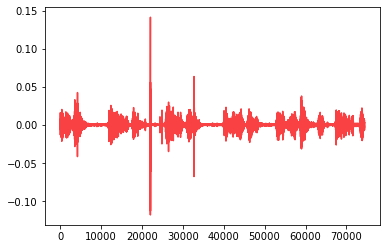

In [23]:
plt.plot(audio)